In [1]:
import os
import json
import h5py
import pyccl
import scipy
import numpy
from matplotlib import pyplot
from matplotlib.gridspec import GridSpec

In [2]:
#Data path
PATH = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'

DATA_PATH = PATH + 'DATA/'

In [3]:
# Path
folder = '/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/'
cell_folder = os.path.join(folder, 'CELL/')
info_folder = os.path.join(folder, 'INFO/')
model_folder = os.path.join(folder, 'MODEL/')
tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='NN'
'''
synthesize_folder = os.path.join(folder, 'SYNTHESIZE/')

tag='Y1'
typ='FIDUCIAL'
label='DOUBLE'
name='NN'

os.makedirs(os.path.join(cell_folder, '{}/'.format(tag)), exist_ok = True)
os.makedirs(os.path.join(cell_folder, '{}/{}'.format(tag, name)), exist_ok = True)
'''
BIN_SIZE = 5
GRID_SIZE = 300
DATA_SIZE = 400000
#float64
REDSHIFT_GRID = numpy.linspace(0.005, 2.995, 300)
# Load
with h5py.File('/global/cfs/cdirs/lsst/groups/MCP/CosmoCloud/SOMZCloud/CALIBRATE/{}/CORRECT/TITANIUM/HYBRID.hdf5'.format(tag), 'r') as file:
    DATA_GRID = numpy.array(file['lens']['data'][:DATA_SIZE, :BIN_SIZE, :GRID_SIZE], dtype = 'double')

In [4]:
# Cosmology
# COSMOLOGY

with open(os.path.join(info_folder, 'COSMOLOGY.json'), 'r') as file:
    
    COSMO = json.load(file)

COSMO_CCL = pyccl.Cosmology(
    h = COSMO['H'],
    w0 = COSMO['W0'],
    wa = COSMO['WA'], 
    n_s = COSMO['NS'], 
    A_s = COSMO['AS'],
    m_nu=COSMO['M_NU'],
    Neff = COSMO['N_EFF'],
    Omega_k = COSMO['OMEGA_K'], 
    Omega_c = COSMO['OMEGA_CDM'], 
    Omega_b = COSMO['OMEGA_B'], 
    Omega_g=COSMO['OMEGA_GAMMA'],
    mass_split = 'single', matter_power_spectrum = 'halofit', transfer_function = 'boltzmann_camb',
    extra_parameters = {'camb': {'kmax': 100, 'lmax': 5000, 'halofit_version': 'mead2020_feedback', 'HMCode_logT_AGN': 7.8}}
)

In [5]:
#Define Kernel

def r_n_k(k, chi, chi_grid):

    grid_size = chi_grid.shape[0] - 1
    n = numpy.max(numpy.where(chi_grid <= chi))

    if chi == 0:

        if k < n < grid_size:

            r = 0
            
        elif n == k < grid_size:

            r = chi_grid[n + 1]**2 / 2 / (chi_grid[n + 1] - chi_grid[n])

        elif n + 1 == k < grid_size:

            r = (chi_grid[n + 2] - chi_grid[n + 1]) / 2 + (chi_grid[n + 1]**2 - 2 * chi_grid[n] * chi_grid[n + 1]) / 2 / (chi_grid[n + 1] - chi_grid[n])

        elif n + 1 < k < grid_size:

            r = (chi_grid[k + 1] - chi_grid[k - 1]) / 2

        elif k == grid_size:

            r = (chi_grid[grid_size] - chi_grid[grid_size - 1]) / 2

        else:

            r = 0

    elif 0 < chi < chi_grid.max():

        if k < n:

            r = 0
            
        elif n == k < grid_size:

            r = (chi_grid[n + 1]**2 - chi**2) / 2 / (chi_grid[n + 1] - chi_grid[n]) - chi * chi_grid[n + 1] / (chi_grid[n + 1] - chi_grid[n]) * numpy.log(chi_grid[n + 1] / chi)

        elif n + 1 == k < grid_size:

            r = (chi_grid[n + 2] - chi_grid[n + 1]) / 2 - chi * chi_grid[n + 2] / (chi_grid[n + 2] - chi_grid[n + 1]) * numpy.log(chi_grid[n + 2] / chi_grid[n + 1]) + (chi_grid[n + 1]**2 - 2 * chi_grid[n] * chi_grid[n + 1] + chi**2) / 2 / (chi_grid[n + 1] - chi_grid[n]) + chi * chi_grid[n] / (chi_grid[n + 1] - chi_grid[n]) * numpy.log(chi_grid[n + 1] / chi)

        elif n + 1 < k < grid_size:

            r = (chi_grid[k + 1] - chi_grid[k - 1]) / 2 - chi * chi_grid[k + 1] / (chi_grid[k + 1] - chi_grid[k]) * numpy.log(chi_grid[k + 1] / chi_grid[k]) + chi * chi_grid[k - 1] / (chi_grid[k] - chi_grid[k-1]) * numpy.log(chi_grid[k] / chi_grid[k - 1])

        elif k == grid_size:

            r = - chi + (chi_grid[grid_size] - chi_grid[grid_size - 1]) / 2 + chi * chi_grid[grid_size - 1] / (chi_grid[grid_size] - chi_grid[grid_size - 1]) * numpy.log(chi_grid[grid_size] / chi_grid[grid_size - 1])

        else:

            r = 0
    
    else:

        r = 0

    return r

def r_n(chi, chi_grid):

    grid_size = chi_grid.shape[0] - 1
    n = numpy.max(numpy.where(chi_grid <= chi))

    r = numpy.zeros(grid_size + 1)
    for k in range(grid_size + 1):
        
        r[k] = r_n_k(k, chi, chi_grid)

    return r

def q_m(chi_data, chi_grid, phi_grid):

    bin_size = phi_grid.shape[0]
    data_size = chi_data.shape[0] - 1
    grid_size = chi_grid.shape[0] - 1
    q = numpy.zeros((bin_size, data_size + 1))

    for n in range(data_size + 1):

        q[:,n] = numpy.sum(r_n(chi_data[n], chi_grid) * phi_grid, axis = 1)
        
    phi = scipy.interpolate.interp1d(chi_grid, phi_grid, kind = 'linear')
    
    return q

def q_m_chi(chi_data, chi_grid, phi_m_grid, type):

    phi_m = scipy.interpolate.interp1d(chi_grid, phi_m_grid, kind = type)
    
    data_size = chi_data.shape[0] - 1
    q = numpy.zeros(data_size + 1)

    for n in range(data_size + 1):
        
        function = lambda chi_prime: phi_m(chi_prime) * (chi_prime - chi_data[n]) / chi_prime
        q[n] = scipy.integrate.fixed_quad(func = function, a = chi_data[n], b = chi_grid.max(), n = 500)[0]

    return q

In [6]:
#Compare different numeric equations

PSI_GRID = numpy.mean(DATA_GRID, axis = 0)
SIGMA_GRID = numpy.std(DATA_GRID, axis = 0)
A_GRID = numpy.array(1 / (1 + REDSHIFT_GRID), dtype = 'double')

CHI_GRID = COSMO_CCL.comoving_radial_distance(a = A_GRID)
PHI_GRID = PSI_GRID * COSMO_CCL.h_over_h0(a = 1 / (1 + REDSHIFT_GRID)) * COSMO['H'] * 100000 / scipy.constants.c

CHI_SIZE = 1000
REDSHIFT_DATA = numpy.linspace(REDSHIFT_GRID.min(), REDSHIFT_GRID.max(), CHI_SIZE + 1)

CHI_DATA = COSMO_CCL.comoving_radial_distance(a = 1 / (1 + REDSHIFT_DATA))
A_DATA = pyccl.background.scale_factor_of_chi(cosmo = COSMO_CCL, chi = CHI_DATA)

KERNEL_CCL = numpy.zeros((BIN_SIZE, CHI_SIZE + 1))
KERNEL_DATA1 = numpy.zeros((BIN_SIZE, CHI_SIZE + 1))
KERNEL_DATA2 = numpy.zeros((BIN_SIZE, CHI_SIZE + 1))
KERNEL_DATA3 = numpy.zeros((BIN_SIZE, CHI_SIZE + 1))
KERNEL_DATA = 3 * (COSMO['OMEGA_M'] ) / 2 * (COSMO['H'] * 100000 / scipy.constants.c)**2 / A_DATA * CHI_DATA * q_m(chi_data = CHI_DATA, chi_grid = CHI_GRID, phi_grid = PHI_GRID)

for BIN_INDEX in range(BIN_SIZE):
    
    KERNEL_DATA1[BIN_INDEX,:] = 3 * (COSMO['OMEGA_M']) / 2 * (COSMO['H'] * 100000 / scipy.constants.c)**2 / A_DATA * CHI_DATA * q_m_chi(chi_data = CHI_DATA, chi_grid = CHI_GRID, phi_m_grid = PHI_GRID[BIN_INDEX,:], type = 'slinear')
    KERNEL_DATA2[BIN_INDEX,:] = 3 * (COSMO['OMEGA_M']) / 2 * (COSMO['H'] * 100000 / scipy.constants.c)**2 / A_DATA * CHI_DATA * q_m_chi(chi_data = CHI_DATA, chi_grid = CHI_GRID, phi_m_grid = PHI_GRID[BIN_INDEX,:], type = 'quadratic')
    KERNEL_DATA3[BIN_INDEX,:] = 3 * (COSMO['OMEGA_M']) / 2 * (COSMO['H'] * 100000 / scipy.constants.c)**2 / A_DATA * CHI_DATA * q_m_chi(chi_data = CHI_DATA, chi_grid = CHI_GRID, phi_m_grid = PHI_GRID[BIN_INDEX,:], type = 'cubic')

    TRACER = pyccl.tracers.WeakLensingTracer(cosmo = COSMO_CCL, dndz = [REDSHIFT_GRID, PSI_GRID[BIN_INDEX,:]], has_shear = True, ia_bias = None, use_A_ia = False, n_samples = GRID_SIZE)
    KERNEL_CCL[BIN_INDEX, :] = TRACER.get_kernel(chi = CHI_DATA)

KERNEL_RATIO = numpy.divide(KERNEL_DATA, KERNEL_CCL, out = numpy.ones(KERNEL_CCL.shape), where = KERNEL_CCL > 0)
KERNEL_RATIO1 = numpy.divide(KERNEL_DATA1, KERNEL_CCL, out = numpy.ones(KERNEL_CCL.shape), where = KERNEL_CCL > 0)
KERNEL_RATIO2 = numpy.divide(KERNEL_DATA2, KERNEL_CCL, out = numpy.ones(KERNEL_CCL.shape), where = KERNEL_CCL > 0)
KERNEL_RATIO3 = numpy.divide(KERNEL_DATA3, KERNEL_CCL, out = numpy.ones(KERNEL_CCL.shape), where = KERNEL_CCL > 0)

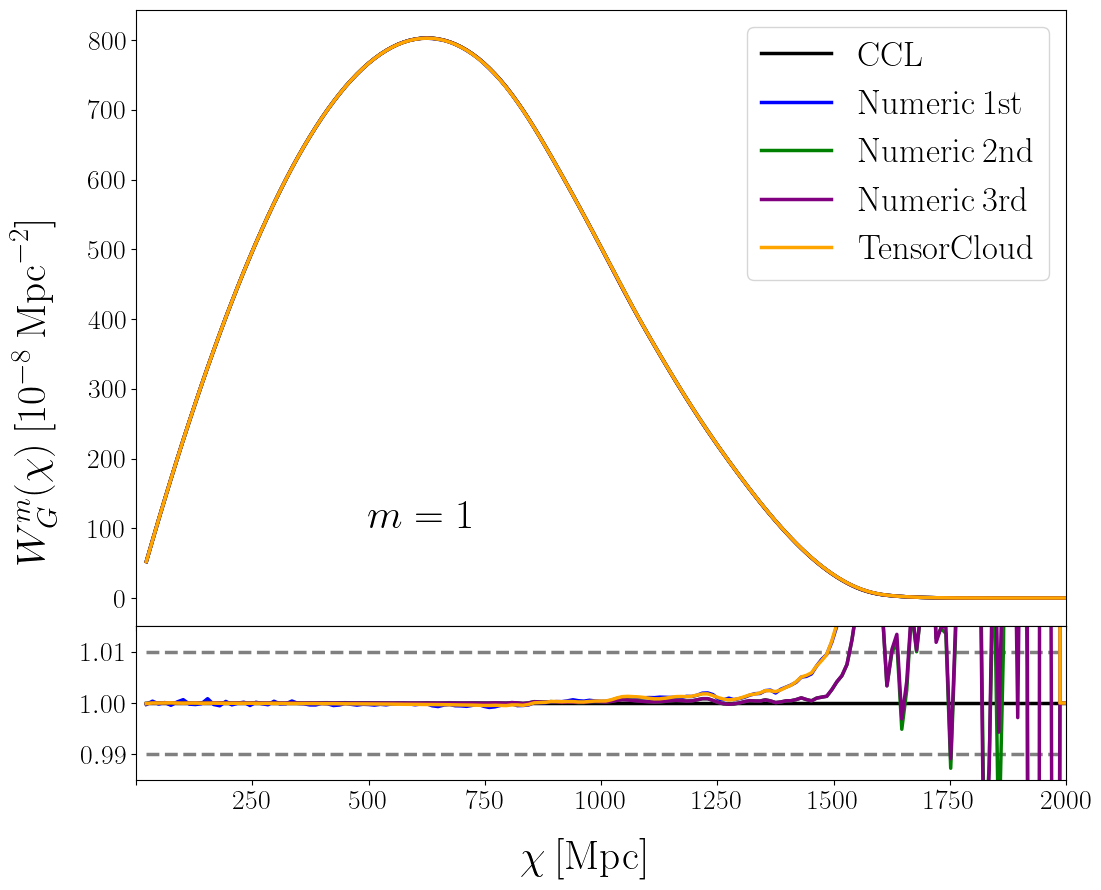

In [7]:
#Plot the results

BIN_INDEX = 0
KERNEL0 = 1e-8
pyplot.rcParams['font.size'] = 20
pyplot.rcParams['text.usetex'] = True
FIGURE = pyplot.figure(figsize = (12, 10))
GRIDSPEC = GridSpec(10, 12, figure = FIGURE, wspace = 0.0, hspace = 0.0)

PLOT = FIGURE.add_subplot(GRIDSPEC[0:8,:])

PLOT.plot(CHI_DATA, KERNEL_CCL[BIN_INDEX,:] / KERNEL0, color = 'black', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{CCL}$')

PLOT.plot(CHI_DATA, KERNEL_DATA1[BIN_INDEX,:] / KERNEL0, color = 'blue', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 1st}$')

PLOT.plot(CHI_DATA, KERNEL_DATA2[BIN_INDEX,:] / KERNEL0, color = 'green', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 2nd}$')

PLOT.plot(CHI_DATA, KERNEL_DATA3[BIN_INDEX,:] / KERNEL0, color = 'purple', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{Numeric \: 3rd}$')

PLOT.plot(CHI_DATA, KERNEL_DATA[BIN_INDEX,:] / KERNEL0, color = 'orange', linestyle = '-', linewidth = 2.5, label = r'$\mathrm{TensorCloud}$')

PLOT.text(x = 500, y = 100, s = r'$m = {:.0f}$'.format(BIN_INDEX + 1), fontsize = 30)

PLOT.set_xlim(0, 2000)
PLOT.legend(loc = 'upper right', fontsize = 25)

PLOT.set_xticklabels([])
PLOT.get_yticklabels()[0].set_visible([])

PLOT = FIGURE.add_subplot(GRIDSPEC[8:,:])

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1), color = 'black', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 + 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)

PLOT.plot(CHI_DATA, numpy.ones(CHI_SIZE + 1) * (1.00 - 0.01), color = 'grey', linestyle = '--', linewidth = 2.5)
          
PLOT.plot(CHI_DATA, KERNEL_RATIO1[BIN_INDEX,:], color = 'blue', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, KERNEL_RATIO2[BIN_INDEX,:], color = 'green', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, KERNEL_RATIO3[BIN_INDEX,:], color = 'purple', linestyle = '-', linewidth = 2.5)

PLOT.plot(CHI_DATA, KERNEL_RATIO[BIN_INDEX,:], color = 'orange', linestyle = '-', linewidth = 2.5)

PLOT.set_xlim(0, 2000)
PLOT.set_ylim(1.000 - 0.015, 1.0 + 0.015)
PLOT.get_xticklabels()[0].set_visible([])

FIGURE.supxlabel(r'$\chi \: [\mathrm{Mpc}]$', fontsize = 30)
FIGURE.supylabel(r'$W_G^m (\chi) \: [10^{-8} \: \mathrm{Mpc}^{-2}]$', fontsize = 30)

FIGURE.subplots_adjust(hspace = 0.0, wspace = 0.0)
FIGURE.savefig('WG.png')
FIGURE.show()